In [1]:
import torch
import torchvision
import random
import torch.nn as nn
import torch.nn.functional as F
from random import gauss
from tqdm import tqdm

In [2]:
def identity(x):
    return x

In [3]:
class InputNeuron():
    def __init__(self, network, priority):
        self.priority = priority
        self.net = network # the network this belongs to
        self.a = torch.tensor(0., requires_grad = False)
        
    def __repr__(self):
        return str(self.priority) + "\t" + str(float(self.a))
        
    def forward(self):
        pass

In [4]:
class Neuron():
    def __init__(self, network, priority, a_func = F.relu):
        self.priority = priority
        self.net = network # the network this belongs to
        
        self.f = a_func
        self.a = torch.tensor(0., requires_grad = True) # The activation value of the neuron
        self.w = torch.tensor([gauss(0,1)],requires_grad = True ) # The weights 
        self.i = torch.tensor([0.], requires_grad = False) # The input values
        
        self.in_keys = [] # keys to grab inputs from
        self.num_connections = 0
        
    def __repr__(self):
        return str(self.priority) + "\t" + str(float(self.a))
            
    
    def forward(self):
        temp = [torch.tensor(1.)] # bias
        for key in self.in_keys:
            temp.append(self.net[key].a)
        self.i = torch.stack(temp)
        self.a = torch.dot(self.i,self.w)
        self.a = self.f(self.a)
        
    def add_connection(self,index):
        self.w.requires_grad = False
        self.w = torch.cat([self.w, torch.tensor([gauss(0,1)])])
        self.i = torch.cat([self.i, torch.tensor([0.])])
        self.w.requires_grad = True
        
        self.in_keys.append(index)
        self.num_connections += 1
        

In [5]:
class Network():
    def __init__(self,n_in,n_out,max_hidden = 5000, out_a_func = identity): 
        # self.net actually links them to their node. 
        self.max = max_hidden
        self.net = {}
        #Priority 0-1 = input, 1-9 = hidden, 9-10 = output
        self.priorities = []
        self.cur = 0
        self.n_in = n_in
        self.n_out = n_out
        self.outputs = torch.empty(n_out, requires_grad=True)
        
        for i in range(n_in):
            p = i/n_in
            self.priorities.append(p)
            self.net[p] = InputNeuron(self, p)
            
        for i in range(n_out):
            p = 9+i/n_out
            self.priorities.append(p)
            self.net[p] = Neuron(self, p, a_func = out_a_func)
            
    def __getitem__(self,key):
        return self.net[key]

    def __iter__(self):
        for p in self.priorities:
            yield self.net[p]
            
    def __call__(self,inputs):
        self.enter(inputs)
        self.forward()
        return self.outputs
    
    def parameters(self):
        params = []
        for p in self.priorities[self.n_in:]:
            params.append(self[p].w)
        return params

    def enter(self,inputs):
        inputs = inputs.view(-1)
        for neuron, t in zip(self,inputs):
            neuron.a = t
            
    def forward(self):
        for p in self.priorities:
            self[p].forward()
        
        temp = []
        for p in self.priorities[-self.n_out:]:
            temp.append(self[p].a)
        self.outputs = torch.stack(temp)
        [n.a.retain_grad() for n in net]
        
    def add_neuron(self,in_connections,out_connections):
        
        min_priority = max(in_connections + [1])
        for p in self.priorities:
            if p > min_priority:
                max_priority = p
                break
        new_priority = (min_priority + max_priority)/2
        self.priorities.append(new_priority)
        self.priorities.sort()
        self.net[new_priority] = Neuron(self,new_priority)
        for i in in_connections:
            self.net[new_priority].add_connection(i)
        for o in out_connections:
            self.net[o].add_connection(new_priority)


net = Network(800,4)
inputs = torch.randn(800)

net.add_neuron([0,0.75,0.875],[9])
net.add_neuron([0.125,0.75,0.875],[9.25])
net.add_neuron([0,0.25,0.5],[9.5])
net.add_neuron([0,0.75,0.375],[9.75])
#net[9].add_connection(0.875)

optimizer = torch.optim.SGD(net.parameters(), lr=.01)
loss_fn = nn.MSELoss()
target = torch.tensor([10.0,5.0,3.0,20.0])

for i in range(1000):
    
    inputs = torch.randn(800)
    out = net(inputs)
    loss = loss_fn(out,target)
    loss.backward()
    
    if i % 100 == 0:
        print(out)
        print(net[9].w)
    #tqdm.write(str(net[9].a.grad))
    
    optimizer.step()
    optimizer.zero_grad()

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

In [7]:
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)

tensor([ 9,  1,  9,  1,  7,  8,  0,  5,  2,  6,  9,  3,  1,  1,
         4,  4,  7,  0,  5,  9,  3,  7,  4,  6,  2,  2,  7,  7,
         3,  1,  3,  7])


Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/keogh1/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/keogh1/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/keogh1/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/keogh1/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/keogh1/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.

In [9]:
net = Network(28*28,10)

#Add random connections
for out in net.priorities[-net.n_out:]:
    for i in range(200):
        net[out].add_connection(random.choice(net.priorities[:-net.n_out]))

In [10]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=0.1)
loss_fn = nn.CrossEntropyLoss()
running_loss = 0
for epoch in range(20):
    for i, data in enumerate(trainloader):
        images, labels = data
        temp = []
        for j in range(batch_size):
            out = net(images[j])
            out = F.softmax(out,dim=0)
            temp.append(out)
        out = torch.stack(temp)
        loss = loss_fn(out,labels)
        loss.backward()
        running_loss += loss
        if i % 100 == 0:
            print(out[0,labels[0]])
            print(running_loss/100)
            running_loss = 0

        optimizer.step()
        optimizer.zero_grad()

tensor(1.00000e-04 *
       1.0013)
tensor(1.00000e-02 *
       2.3556)
tensor(1.00000e-05 *
       8.2613)
tensor(2.2934)
tensor(1.00000e-03 *
       6.8134)
tensor(2.2391)
tensor(0.5518)
tensor(2.1297)
tensor(0.7814)
tensor(2.1010)
tensor(0.5462)
tensor(2.0809)
tensor(1.00000e-02 *
       9.9935)
tensor(2.0463)
tensor(1.00000e-02 *
       1.4612)
tensor(2.0669)
tensor(1.00000e-03 *
       7.7257)
tensor(2.0576)
tensor(0.8414)
tensor(2.0641)
tensor(0.4435)
tensor(2.0619)
tensor(0.1555)
tensor(2.0561)
tensor(1.00000e-02 *
       2.8795)
tensor(2.0458)
tensor(0.5647)
tensor(2.0603)
tensor(1.00000e-02 *
       1.9088)
tensor(2.0593)
tensor(0.5694)
tensor(2.0859)
tensor(1.00000e-02 *
       1.4740)
tensor(2.0497)
tensor(1.00000e-02 *
       1.6112)
tensor(2.0988)


Process Process-4:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/keogh1/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/keogh1/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/keogh1/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/keogh1/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/keogh1/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.

Traceback (most recent call last):
  File "/Users/keogh1/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-c4e92f314bd5>", line 9, in <module>
    out = net(images[j])
  File "<ipython-input-5-d9b034cde9d6>", line 31, in __call__
    self.enter(inputs)
  File "<ipython-input-5-d9b034cde9d6>", line 43, in enter
    for neuron, t in zip(self,inputs):
  File "<ipython-input-5-d9b034cde9d6>", line 28, in __iter__
    yield self.net[p]
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/keogh1/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Trace

KeyboardInterrupt: 

tensor(7) tensor(7)
tensor(3) tensor(3)
tensor(4) tensor(7)
tensor(1) tensor(1)
tensor(4) tensor(8)
tensor(4) tensor(4)
tensor(0) tensor(0)
tensor(1) tensor(1)
tensor(1) tensor(2)
tensor(1) tensor(1)
tensor(1) tensor(9)
tensor(3) tensor(5)
tensor(6) tensor(6)
tensor(1) tensor(1)
tensor(4) tensor(9)
tensor(1) tensor(1)
tensor(1) tensor(2)
tensor(4) tensor(4)
tensor(3) tensor(3)
tensor(0) tensor(0)
tensor(1) tensor(1)
tensor(1) tensor(1)
tensor(0) tensor(0)
tensor(4) tensor(4)
tensor(1) tensor(1)
tensor(3) tensor(8)
tensor(1) tensor(7)
tensor(0) tensor(8)
tensor(0) tensor(0)
tensor(4) tensor(9)
tensor(1) tensor(7)
tensor(4) tensor(9)
tensor(4) tensor(4)
tensor(1) tensor(2)
tensor(7) tensor(9)
tensor(1) tensor(8)
tensor(7) tensor(9)
tensor(1) tensor(2)
tensor(1) tensor(7)
tensor(6) tensor(8)
tensor(1) tensor(1)
tensor(4) tensor(8)
tensor(1) tensor(6)
tensor(4) tensor(5)
tensor(0) tensor(0)
tensor(4) tensor(4)
tensor(1) tensor(3)
tensor(0) tensor(0)
tensor(6) tensor(6)
tensor(3) tensor(8)


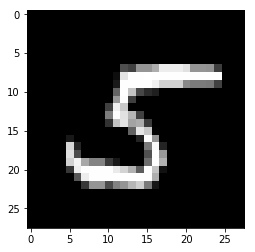

In [28]:
correct = 0
it = iter(testloader)
for i in range(200):
    images, labels = it.next()

    imshow(torchvision.utils.make_grid(images[0]))
    out = net(images[0])
    _, index = torch.max(out,0)
    if(index == labels[0]):
        correct += 1
    print(index,labels[0])
print(correct)
